In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -q /content/drive/MyDrive/all_data/coloring_dataset-v0.3.zip

In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 22.9 MB/s eta 0:00:00


In [ ]:
!pip install -q tensorflow_docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 6.7 MB/s eta 0:00:00


#**🔴Import Libs**

In [ ]:
import os
from glob import glob
import random
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import PIL
from PIL import Image
import cv2
import time
import imageio.v2 as imageio
from tensorflow_docs.vis import embed
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import io
from torchvision.transforms import v2
import torchvision.transforms.functional as F
from torchvision.datasets import VisionDataset
from torchvision import tv_tensors
from torchvision.utils import make_grid

import tqdm
import torchmetrics as tm
from torchmetrics import MeanMetric
import random
import warnings
warnings.filterwarnings('ignore')


In [ ]:
for lib in [np, torch, torchvision, tm, cv2, PIL, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.5.1+cu121
torchvision --> 0.20.1+cu121
torchmetrics --> 1.6.0
cv2 --> 4.10.0
PIL --> 11.0.0
tqdm --> 4.67.1


#**🔴Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False


In [ ]:
def time_for_each_batch(loader):
  start = time.time()
  for iter, (img, mask) in enumerate(loader, 1):
    continue
  end = time.time()
  total_time = end - start
  return total_time, total_time/len(loader)

#**🔴Arguments**

In [ ]:
root = Path('/content/v0.3/processed/')
metadata = pd.read_csv(root/'train/metadata.csv')

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(metadata[['hair', 'shirt']])

OneHotEncoder(handle_unknown='ignore')

In [ ]:
seed = 8
color_list = ['blue', 'brown', 'red', 'yellow', 'green']
wandb_enable = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 10
lr = 0.01
num_epochs = 100
pic_dim = 64 * 64
im_size = 64
num_cls = 5

In [ ]:
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)


#**🔴Dataset**

In [ ]:
transform_train = v2.Compose([
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    ])

transform_test = v2.Compose([
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    ])

In [ ]:
condition = metadata[['hair', 'shirt']].values.tolist()
cons = torch.LongTensor([enc.transform([i]).toarray() for i in condition]).view(250, -1, 1, 1)
cons.shape

torch.Size([250, 10, 1, 1])

In [ ]:
class ColoringDataset(Dataset):
  def __init__(self, root, phase, transform=None):

    self.metadata = pd.read_csv(root/f'{phase}/metadata.csv')
    self.transform = transform
    condition = self.metadata[['hair', 'shirt']].values.tolist()
    self.conditions = torch.LongTensor([enc.transform([i]).toarray() for i in condition])
    self.images = []
    self.targets = []

    for i in range(len(self.metadata)):
      image = tv_tensors.Image(Image.open(root/f'{phase}/inputs/{self.metadata.iloc[i, 0]}'))
      target = tv_tensors.Image(Image.open(root/f'{phase}/targets/{self.metadata.iloc[i, 1]}'))
      if self.transform:
        self.images.append(self.transform(image))
        self.targets.append(self.transform(target))
      else:
        self.images.append(image)
        self.targets.append(target)

  def __len__(self):
    return len(self.metadata)

  def __getitem__(self, index):
      return self.images[index], self.targets[index], self.conditions[index].view(-1, 1, 1)

In [ ]:
train = ColoringDataset(root, 'train', transform=transform_train)
test = ColoringDataset(root, 'test', transform=transform_test)

In [ ]:
im, tar, con= train.__getitem__(26)
im.shape, tar.shape, con.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]), torch.Size([10, 1, 1]))

torch.Size([10, 1, 1])


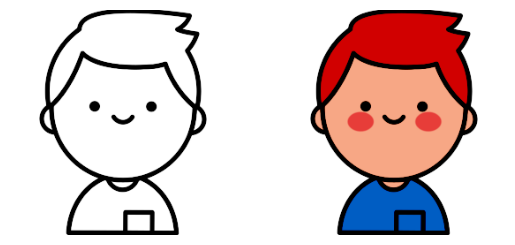

In [ ]:
idx = random.randint(0, len(train)-1)
src, tgt, vecs = train[idx]

fig, axes = plt.subplots(1, 2)
axes[0].imshow(src.permute(1, 2, 0)), axes[0].axis('off')
axes[1].imshow(tgt.permute(1, 2, 0)), axes[1].axis('off');

print(vecs.shape)

In [ ]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
im, tar, con = next(iter(train_loader))
im.shape, tar.shape, con.shape

(torch.Size([10, 3, 256, 256]),
 torch.Size([10, 3, 256, 256]),
 torch.Size([10, 10, 1, 1]))

#**🔴Block Diagrams**

###🧩Generator

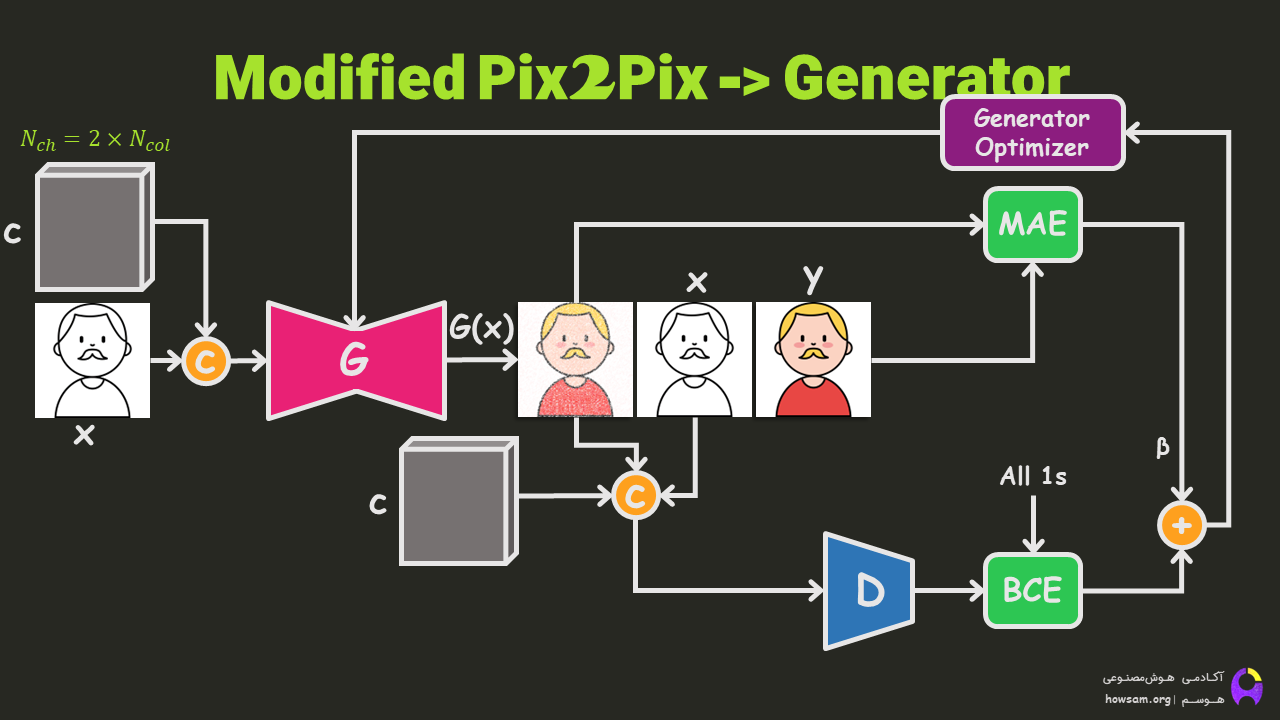

###🧩Discriminator

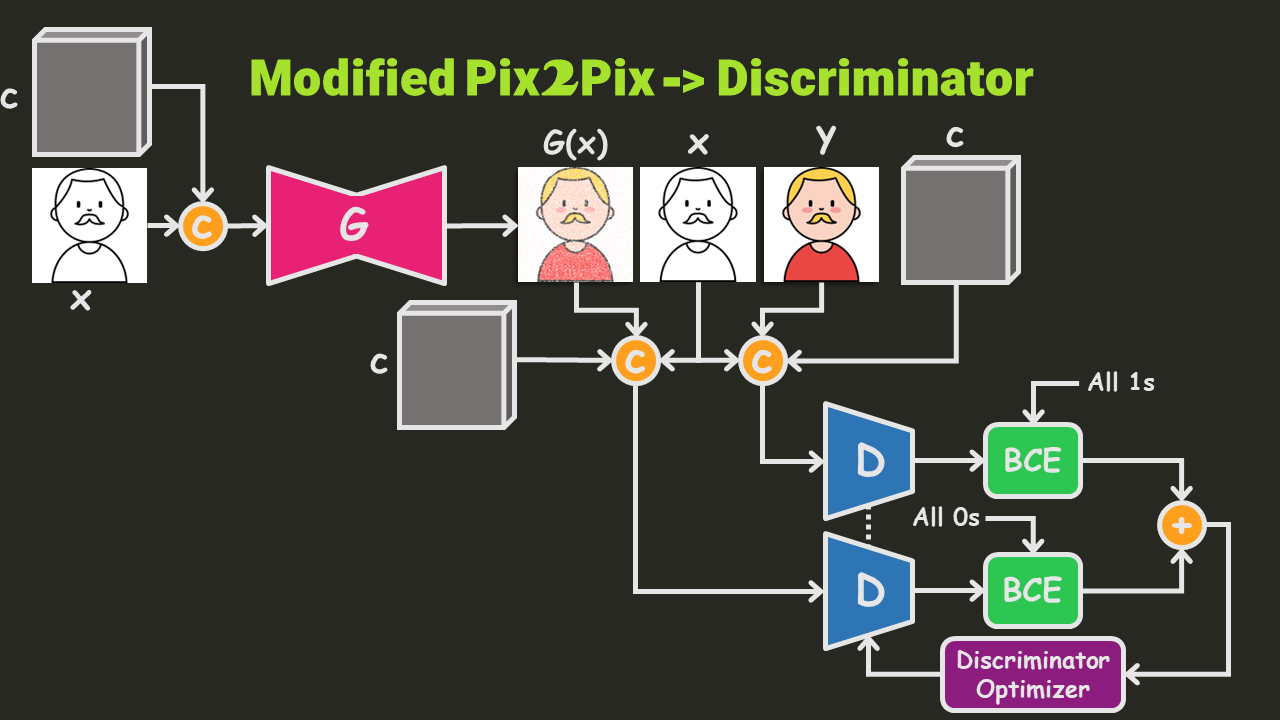

#**🔴Model**

###⚪Encoder block

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=4, batchnorm=True):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels) if batchnorm else None
    self.af = nn.LeakyReLU(0.2, inplace=True)

  def forward(self, x):
    x = self.conv(x)
    if self.bn:
      x = self.bn(x)
    x = self.af(x)
    return x

In [ ]:
encoder_block = EncoderBlock(in_channels=3, out_channels=64, kernel_size=4, batchnorm=True)
with torch.no_grad():
  tmp = encoder_block(torch.randn(1, 3, 256, 256))
tmp.shape

torch.Size([1, 64, 128, 128])

###⚪Decoder block

In [ ]:
class DecoderBlock(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=4, dropout=False):
    super().__init__()
    self.tconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels)
    self.dropout = nn.Dropout(0.5) if dropout else None
    self.af = nn.ReLU()

  def forward(self, x):
    x = self.tconv(x)
    x = self.bn(x)
    if self.dropout:
      x = self.dropout(x)
    x = self.af(x)
    return x

In [ ]:
decoder_block = DecoderBlock(in_channels=512, out_channels=256, dropout=False)
tmp = decoder_block(torch.randn(2, 512, 4, 4))
tmp.shape

torch.Size([2, 256, 8, 8])

###🟡Generator

In [ ]:
class Generator(nn.Module):

  def __init__(self, in_channels=13):
    super().__init__()

    nc = [in_channels, 64, 128, 256, 512, 512, 512, 512, 512]
    self.encoders = nn.ModuleList([
        EncoderBlock(nc[i-1], nc[i], batchnorm=False if i==1 else True) for i in range(1, len(nc))
    ])
    nc.reverse()
    self.decoders = nn.ModuleList([
        DecoderBlock(2*nc[i-1] if i>1 else nc[i-1], nc[i], dropout=True if i<4 else False) for i in range(1, len(nc[:-1]))
    ])

    self.last = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)
    self.tanh = nn.Tanh()

  def forward(self, x, c):
    # Concat
    _, _, h, w = x.shape
    c = c.repeat(1, 1, h, w)
    x = torch.cat((x, c), dim=1)

    # Encoder
    skips = []
    for encoder in self.encoders:
      x = encoder(x)
      skips.append(x)

    skips = reversed(skips[:-1])

    # Decoder
    for decoder, skip in zip(self.decoders, skips):
      x = decoder(x)
      x = torch.cat((x, skip), 1)

    out = self.last(x)
    out = self.tanh(out)

    return out

In [ ]:
generator = Generator(in_channels=13)
tmp = generator(torch.randn(2, 3, 256, 256), torch.randn(2, 10, 1, 1))
tmp.shape

torch.Size([2, 3, 256, 256])

###🟡Discriminator

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, in_channels=16):
    super().__init__()
    nc = [in_channels, 64, 128, 256]
    self.layers = nn.ModuleList([
        EncoderBlock(nc[i-1], nc[i], batchnorm=True if i>1 else False) for i in range(1, len(nc))
    ])

    self.layers += nn.Sequential(
        nn.ZeroPad2d(padding=1),
        nn.Conv2d(256, 512, kernel_size=4, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2))

    self.layers += nn.Sequential(
        nn.ZeroPad2d(1),
        nn.Conv2d(512, 1, kernel_size=4)
    )

  def forward(self, x, y, c):
    # Concat
    _, _, h, w = x.shape
    c = c.repeat(1, 1, h, w)
    x = torch.cat((x, y, c), dim=1)

    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
discriminator = Discriminator(in_channels=16)
tmp = discriminator(torch.randn(2, 3, 256, 256), torch.randn(2, 3, 256, 256), torch.randn(2, 10, 1, 1))
tmp.shape

torch.Size([2, 1, 30, 30])

###🟡Try the model

In [ ]:
x, y, c = next(iter(train_loader))
print(x.shape, y.shape, c.shape)

torch.Size([10, 3, 256, 256]) torch.Size([10, 3, 256, 256]) torch.Size([10, 10, 1, 1])


In [ ]:
generator = Generator(in_channels=13)
discriminator = Discriminator(in_channels=16)


In [ ]:
tmp = generator(x, c)
tmp.shape

torch.Size([10, 3, 256, 256])

In [ ]:
tmp = discriminator(x, y, c)
tmp.shape

torch.Size([10, 1, 30, 30])

In [ ]:
tmp = discriminator(x, generator(x, c), c)
tmp.shape

torch.Size([10, 1, 30, 30])

#**🔴Train**

##🟠Train Function

In [ ]:
def train_one_epoch(generator, discriminator,
                    train_loader,
                    generator_loss_fn, discriminator_loss_fn,
                    generator_optimizer, discriminator_optimizer,
                    epoch=None):

  generator.train()
  discriminator.train()

  gen_total_loss, disc_total_loss = MeanMetric(), MeanMetric()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets, conditions in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)
      conditions = conditions.to(device)

      # Generator's loss
      gen_outputs = generator(inputs, conditions)
      disc_gen_outputs = discriminator(inputs, gen_outputs, conditions)
      gen_loss = generator_loss_fn(disc_gen_outputs, gen_outputs, targets)

      # Discriminator's loss
      # with torch.no_grad():
      #   gen_outputs = generator(inputs, conditions)
      # gen_outputs = gen_outputs.detach()
      gen_outputs = generator(inputs, conditions).detach()
      disc_gen_outputs = discriminator(inputs, gen_outputs, conditions)
      disc_real_outputs = discriminator(inputs, targets, conditions)
      disc_loss = discriminator_loss_fn(disc_real_outputs, disc_gen_outputs)

      # Generator's params update
      generator_optimizer.zero_grad()
      gen_loss.backward()
      generator_optimizer.step()

      # Discriminator's params update
      discriminator_optimizer.zero_grad()
      disc_loss.backward()
      discriminator_optimizer.step()

      gen_total_loss.update(gen_loss.item(), weight=len(inputs))
      disc_total_loss.update(disc_loss.item(), weight=len(inputs))

      tepoch.set_postfix(
          lossG=gen_total_loss.compute().item(),
          lossD=disc_total_loss.compute().item()
          )

  return gen_total_loss.compute().item(), disc_total_loss.compute().item()

##🟠Evaluation

In [ ]:
def evaluate(generator, test_loader, loss_fn):

  loss_eval = MeanMetric()

  with torch.inference_mode():
    for inputs, targets, conditions in test_loader:

      inputs = inputs.to(device)
      targets = targets.to(device)
      conditions = conditions.to(device)

      outputs = generator(inputs, conditions)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), weight=len(targets))

  return loss_eval.compute().item()

##🟠Generate

In [ ]:
def generate(generator, valid_loader, filename='img.png'):

  inputs, targets, conditions = next(iter(valid_loader))
  inputs = inputs.to(device)
  conditions = conditions.to(device)

  with torch.inference_mode():
    outputs = generator(inputs, conditions)

  outputs = (255*(0.5*outputs + 0.5)).byte().cpu()
  targets = (255*(0.5*targets + 0.5)).byte().cpu()

  imgs = [t for t in targets] + [o for o in outputs]
  grid = make_grid(imgs, nrow=10)

  io.write_png(grid, filename)

##🟠W&B

In [ ]:
if wandb_enable:
    key_file = '/content/key'

    if os.path.exists(key_file):
        with open(key_file) as f:
            key = f.readline().strip()
        wandb.login(key=key)
    else:
        print("Key file does not exist. Please create the key file with your wandb API key.")

#**🔴Training Process**

##🟠Loss

In [ ]:
class GeneratorLoss(nn.Module):

  def __init__(self, LAMBDA=100):
    super().__init__()
    self.LAMBDA = LAMBDA
    self.l1 = nn.L1Loss()
    self.bce = nn.BCEWithLogitsLoss()

  def forward(self, disc_generated_output, gen_output, target):
    l1_loss = self.l1(gen_output, target)

    all_ones = torch.ones_like(disc_generated_output)
    gan_loss = self.bce(disc_generated_output, all_ones)

    total_gan_loss = gan_loss + self.LAMBDA * l1_loss

    return total_gan_loss

In [ ]:
class DiscriminatorLoss(nn.Module):

  def __init__(self):
    super().__init__()
    self.bce = nn.BCEWithLogitsLoss()

  def forward(self, disc_real_output, disc_generated_output):
    all_ones = torch.ones_like(disc_real_output)
    real_loss = self.bce(disc_real_output, all_ones)

    all_zeros = torch.zeros_like(disc_generated_output)
    generated_loss = self.bce(disc_generated_output, all_zeros)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

##🟠Optimizer

In [ ]:
optimizer_g = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

##🟠Main Loop

In [ ]:
torch.cuda.empty_cache()

In [ ]:
set_seed(seed)

generator = Generator(in_channels=13).to(device)
discriminator = Discriminator(in_channels=16).to(device)

In [ ]:
gen_loss_fn = GeneratorLoss(LAMBDA=100)
disc_loss_fn = DiscriminatorLoss()

In [ ]:
set_seed(seed)

lr = 0.0001
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
if wandb_enable:
  wandb.init(
      project=...,
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'dropout_embed': dropoute,
          'dropout_in_lstm': dropouti,
          'dropout_h_lstm': dropouth,
          'dropout_out_lstm': dropouto,
          'clip': clip,
      }
  )

In [ ]:
loss_gen_hist = []
loss_disc_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 50
root = '/content/drive/MyDrive/Colorize'

for epoch in range(num_epochs):
  # Train
  gen_loss, disc_loss = train_one_epoch(
      generator, discriminator,
      train_loader,
      gen_loss_fn, disc_loss_fn,
      gen_optimizer, disc_optimizer,
      epoch+1)

  # Validation
  loss_valid = evaluate(
      generator,
      test_loader,
      nn.MSELoss())

  generate(generator, test_loader, f'{root}/results/img-{epoch_counter+1}.png')

  loss_gen_hist.append(gen_loss)
  loss_disc_hist.append(disc_loss)
  loss_valid_hist.append(loss_valid)

  if loss_valid < best_loss_valid:
    torch.save(generator, f'{root}/weights/generator-best.pt')
    best_loss_valid = loss_valid
    print('Generator Saved!')

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  # if wandb_enable:
  #   wandb.log({"metric_train": metric_train, "loss_train": loss_train,
  #               "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

torch.save(generator, f'{root}/generator-last.pt')

Epoch 1: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=2.62]


Valid: Loss = 0.0168



Epoch 2: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=2.16]


Generator Saved!
Valid: Loss = 0.01587



Epoch 3: 100%|██████████| 25/25 [00:11<00:00,  2.10batch/s, lossD=1.37, lossG=2.28]


Valid: Loss = 0.01625



Epoch 4: 100%|██████████| 25/25 [00:11<00:00,  2.11batch/s, lossD=1.38, lossG=2.23]


Valid: Loss = 0.01671



Epoch 5: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=2.25]


Valid: Loss = 0.01648



Epoch 6: 100%|██████████| 25/25 [00:11<00:00,  2.15batch/s, lossD=1.37, lossG=2.05]


Valid: Loss = 0.01655



Epoch 7: 100%|██████████| 25/25 [00:11<00:00,  2.16batch/s, lossD=1.38, lossG=2.06]


Valid: Loss = 0.01666



Epoch 8: 100%|██████████| 25/25 [00:11<00:00,  2.15batch/s, lossD=1.39, lossG=2.05]


Valid: Loss = 0.01602



Epoch 9: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=2.17]


Valid: Loss = 0.01617



Epoch 10: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=2.08]


Valid: Loss = 0.01633



Epoch 11: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=2.17]


Valid: Loss = 0.01652



Epoch 12: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.37, lossG=2.16]


Valid: Loss = 0.01629



Epoch 13: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=2.11]


Valid: Loss = 0.01677



Epoch 14: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=2.1]


Valid: Loss = 0.01612



Epoch 15: 100%|██████████| 25/25 [00:11<00:00,  2.15batch/s, lossD=1.38, lossG=2.05]


Valid: Loss = 0.0171



Epoch 16: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=1.99]


Valid: Loss = 0.01679



Epoch 17: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=2.09]


Valid: Loss = 0.01611



Epoch 18: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.39, lossG=2]


Valid: Loss = 0.01663



Epoch 19: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=1.99]


Valid: Loss = 0.01648



Epoch 20: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=1.99]


Valid: Loss = 0.01666



Epoch 21: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=1.95]


Valid: Loss = 0.01656



Epoch 22: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=1.96]


Valid: Loss = 0.01633



Epoch 23: 100%|██████████| 25/25 [00:11<00:00,  2.15batch/s, lossD=1.38, lossG=1.89]


Valid: Loss = 0.01622



Epoch 24: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.37, lossG=1.96]


Valid: Loss = 0.01689



Epoch 25: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=1.87]


Valid: Loss = 0.01678



Epoch 26: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=1.89]


Valid: Loss = 0.01625



Epoch 27: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=1.93]


Valid: Loss = 0.0166



Epoch 28: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.37, lossG=1.91]


Valid: Loss = 0.0165



Epoch 29: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=1.83]


Valid: Loss = 0.01724



Epoch 30: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.37, lossG=2]


Valid: Loss = 0.01635



Epoch 31: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=1.95]


Valid: Loss = 0.01698



Epoch 32: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=1.84]


Valid: Loss = 0.01609



Epoch 33: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=1.84]


Valid: Loss = 0.0172



Epoch 34: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=1.92]


Valid: Loss = 0.01675



Epoch 35: 100%|██████████| 25/25 [00:11<00:00,  2.13batch/s, lossD=1.38, lossG=1.84]


Valid: Loss = 0.01631



Epoch 36: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=1.89]


Valid: Loss = 0.01646



Epoch 37: 100%|██████████| 25/25 [00:11<00:00,  2.14batch/s, lossD=1.38, lossG=1.88]


Valid: Loss = 0.01665



Epoch 38:   8%|▊         | 2/25 [00:01<00:16,  1.44batch/s, lossD=1.29, lossG=2.52]


KeyboardInterrupt: 

##🟠Plot

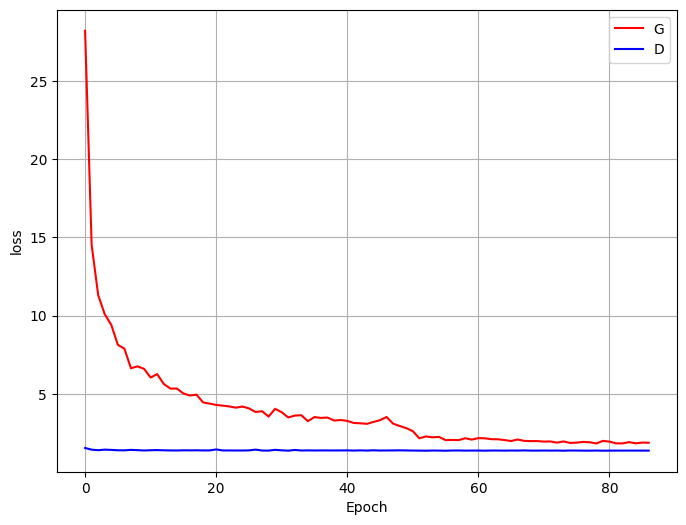

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_gen_hist, 'r-', label='G')
plt.plot(range(epoch_counter), loss_disc_hist, 'b-', label='D')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

#**🔴Generate**

In [ ]:
model = torch.load('/content/drive/MyDrive/Colorize/generator-last.pt').to(device)

In [ ]:
root = '/content/drive/MyDrive/Colorize'
filenames = glob(f'{root}/results/*')
filenames = sorted(filenames, key=lambda x: int(x.split('-')[-1].split('.')[0]))
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(f'{root}/animation.gif', images, duration = 0.04)

In [ ]:
embed.embed_file(f"{root}/animation.gif")